In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle 
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import copy

import pyPSFstack.pupils.sources as srcs
import pyPSFstack.pupils.windows as wdws
from pyPSFstack.pupils.aberrations import UnitaryZernike, ScalarZernike, UnitaryPixels
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
import pyPSFstack.diversities.pola_diversities as pdivs
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring.blurring import ExactBlurring

from torchPSFstack.psf_modules import torchPSFStack
from torchPSFstack.pupils.sources import torchDipoleInterfaceSource
from torchPSFstack.pupils.windows import torchSEO
from torchPSFstack.pupils.aberrations import torchUnitaryZernike, \
    torchScalarZernike, torchScalarPixels
from torchPSFstack.diversities.pupil_diversities import torchZDiversity
from torchPSFstack.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from torchPSFstack.blurring.blurring import torch2DBlurring, torchSABlurring
from torchPSFstack.cost_functions import loss_loglikelihood, loss_sumsquared
from torchPSFstack.functions import get_pupils_param_dict, get_normNbck, colorize


from functions4man import plot_zpstack, plot_zstack, plot_xyz, plot_jones, \
    get_xyzstack, find_pupil, cpx_corr
    
fig_folder='figures'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['mathtext.fontset'] = 'cm'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({"figure.facecolor" : "white"})
matplotlib.rcParams['font.family'] = 'Helvetica'
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
# SMALL_SIZE = 9
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 


# Characterizing a birefringent window from a PSF stack

## Define parameters 

In [2]:
# Define number of points use for the computation 
N_pts = 128

# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.515
cam_pixel_size = 6500 # in nm
radius = 10 # of the nanobead in nm
wavelength = 605
dipole_orientation = [0,0,0] # this means incoherent

# Define positions of defocus
zi = -500; z_step = 100 # in nm
z_list = np.arange(zi,-zi+z_step,z_step)
z_list_np = np.arange(zi,-zi+z_step/8,z_step/8)

# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)

# For computing exact 3D blurring
blurring_slices = 21

We put all the parameters in a dictionary 

In [3]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = (radius + np.random.rand()*20 )/wavelength
# params['source']['alpha'] = 0

params['defocus'] = {}
params['defocus']['nf'] = nf
params['defocus']['delta_z'] =  (np.random.rand()-0.5)*50/wavelength

params['qplate'] = {}
params['qplate']['q'] = 1/2

params['seo'] = {}
params['seo']['c'] = 1.25*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['zdiversity_np'] = {}
params['zdiversity_np']['z_list'] = z_list_np / wavelength
params['zdiversity_np']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['qwp_angles'] = angle_list
params['pdiversity']['lp_angles'] = [0,np.pi/2]

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 


params_ret = copy.deepcopy(params)

params_ret['aberrations'] = {}
params_ret['aberrations']['jmax_list'] = [15]*4+[15]
params_ret['source']['delta'] = radius/wavelength

# params_ret['source']['alpha'] = None
params_ret['defocus']['delta_z'] = 0

Instantiate all the class elements need to define a PSF stack

In [4]:
# source terms
src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])

# Windows for numerical experiments
seo = wdws.SEO(**params['pupil'],**params['seo'])
qplate = wdws.Qplate(**params['pupil'],**params['qplate'])

# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
zdiv_np = ZDiversity(**params['zdiversity_np'], **params['pupil'])
qwp = pdivs.PDiversity_QWP(angle_list)
wollaston = pdivs.PDiversity_LP([0, np.pi/2])
pdiv = pdivs.PDiversity_Compound([qwp, wollaston])
pol_seo = pdivs.PDiversity_Compound([pdivs.PDiversity_QWP([np.pi/4]), wollaston])

# Finally the blurring even if it is small
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

# hwp = pdivs.PDiversity_HWP(angle_list)
# pdiv2 = pdivs.PDiversity_Compound([hwp, wollaston])



In [5]:
def get_dNzf(psfs):
    delta = psfs.pupils[0].delta
    alpha = psfs.pupils[0].alpha
    delta_z = 0
    # if len(psfs.pupils)==3:
    delta_z = psfs.pupils[1].delta_z
    return delta, delta_z + alpha * delta

## I. With and without polarization diversity

### I.1. SEO

In [6]:
fig_sub_folder = 'seo_ret'

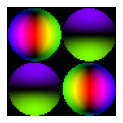

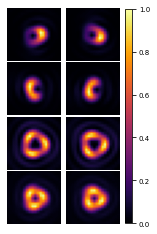

In [7]:
plot_jones(seo.get_pupil_array())
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'jones_seo.pdf'), bbox_inches='tight')
stack_xyz = get_xyzstack([src, seo], pol_seo)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'seo_stackxyz.pdf'), bbox_inches='tight')

####  With polarization diversity

In [8]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

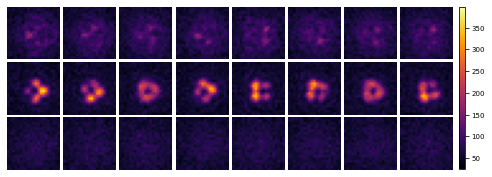

In [9]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=21,noise=True)
plot_zpstack(data_stack, N_p=8)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'stack.pdf'), bbox_inches='tight')

100%|██████████| 200/200 [00:27<00:00,  7.37it/s]


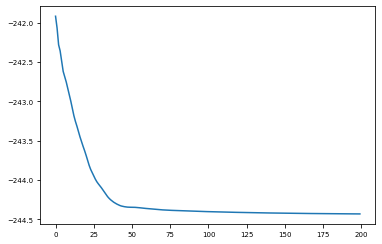

In [10]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
    opt_def=True, opt_delta=False)
plt.plot(loss_evol)

0.04785006232859074 tensor(0.0165)
0.08445702405481184 tensor(0.0571)
0.9984701166661951


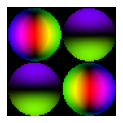

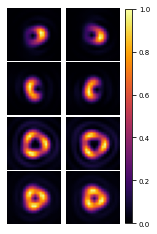

In [12]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)

abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
print(np.abs(cpx_corr(abe.get_pupil_array(), seo.get_pupil_array())))

plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retzp.pdf'), bbox_inches='tight')

stack_xyz = get_xyzstack([src, abe], pol_seo)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retzp.pdf'), bbox_inches='tight')

#### With a pixel model

100%|██████████| 200/200 [00:20<00:00,  9.66it/s]


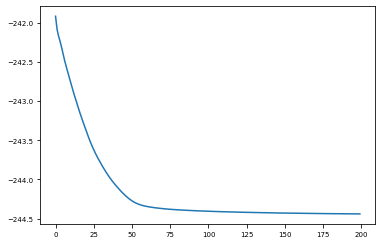

In [13]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
    opt_def=False, opt_delta=False, abe='pix')
plt.plot(loss_evol)

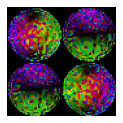

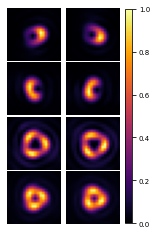

In [22]:
retpix_pupil_params = get_pupils_param_dict(model)
abe_pix = UnitaryPixels(**params['pupil'], 
     **retpix_pupil_params['pupil1'])

plot_jones(abe_pix.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retzp_pix.pdf'), bbox_inches='tight')

stack_xyz = get_xyzstack([src, abe_pix], pol_seo)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retzp_pix.pdf'), bbox_inches='tight')

#### Without polarization diversity

In [31]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv_np, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

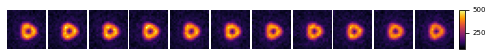

In [32]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=21,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


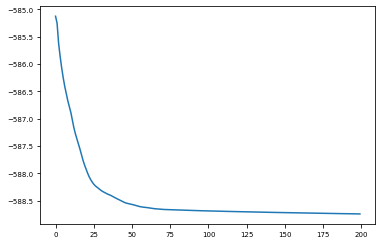

In [33]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
                              loss_fn=loss_loglikelihood, pdiv=None)
plt.plot(loss_evol)

0.020283914283488233 tensor(0.0165)
0.03643543946814319 tensor(0.0489)


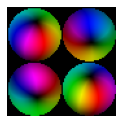

In [34]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_seo_retz.pdf'), bbox_inches='tight')

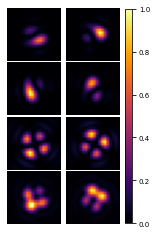

In [35]:
stack_xyz = get_xyzstack([src, abe], pol_seo)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'seo_stackxyz_retz.pdf'), bbox_inches='tight')

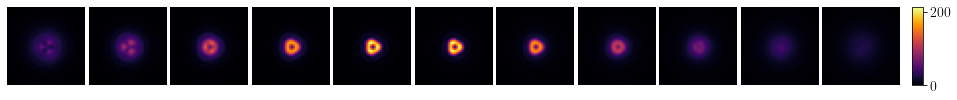

In [24]:
psfs_ret = PSFStack([src, defocus, abe], zdiversity=zdiv, blurring=blurring)
psfs_ret.compute_psf_stack(orientation=[0,0,0])
ret_stack = psfs_ret.model_experimental_stack(bckgd_photons=0,N_photons=10000,N_pts=40,noise=False)
plot_zstack(ret_stack, N_z=11)

### I.2. Qplate

In [23]:
fig_sub_folder = 'qp_ret'

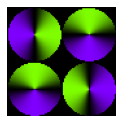

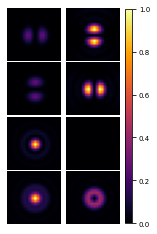

In [24]:
plot_jones(qplate.get_pupil_array())
# plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp.pdf'), bbox_inches='tight')
stack_xyz = get_xyzstack([src, qplate], wollaston)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz.pdf'), bbox_inches='tight')

#### With polarization diversity

In [25]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

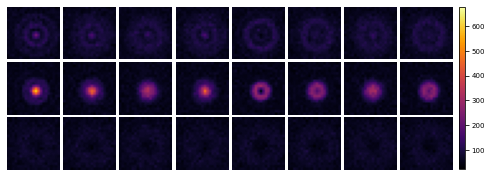

In [26]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,
                                           N_pts=21,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 250/250 [00:24<00:00, 10.32it/s]


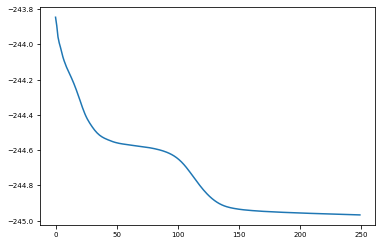

In [27]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=250, 
    loss_fn=loss_loglikelihood)
plt.plot(loss_evol)

0.04785006232859074 tensor(0.0165)
0.08445702405481184 tensor(0.0633)


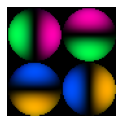

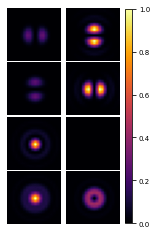

In [28]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta#ret_pupil_params['pupil0']['delta'] 
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retzp.pdf'), bbox_inches='tight')

stack_xyz = get_xyzstack([src, abe], wollaston)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retzp.pdf'), bbox_inches='tight')

#### With a pixel model

100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


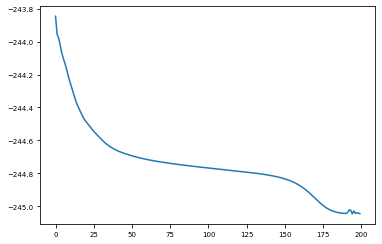

In [29]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
    opt_def=False, opt_delta=False, abe='pix')
plt.plot(loss_evol)

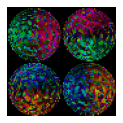

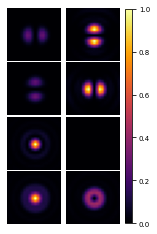

In [31]:
retpix_pupil_params = get_pupils_param_dict(model)
abe_pix = UnitaryPixels(**params['pupil'], 
     **retpix_pupil_params['pupil1'])

plot_jones(abe_pix.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retzp_pix.pdf'), bbox_inches='tight')

stack_xyz = get_xyzstack([src, abe_pix], wollaston)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retzp_pix.pdf'), bbox_inches='tight')

#### Without polarization diversity

In [32]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv_np, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0])

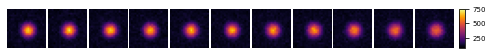

In [33]:
data_stack = psfs.model_experimental_stack(bckgd_photons=100,N_photons=20000,N_pts=21,noise=True)
plot_zstack(data_stack, N_z=11)

100%|██████████| 400/400 [03:45<00:00,  1.78it/s]


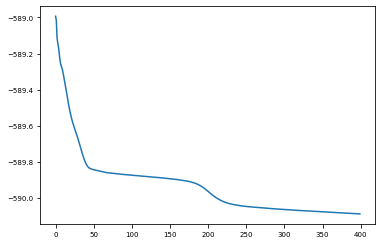

In [34]:
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=400, 
                              loss_fn=loss_loglikelihood, pdiv=None)
plt.plot(loss_evol)

0.04785006232859074 tensor(0.0165)
0.08445702405481184 tensor(0.0708)


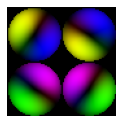

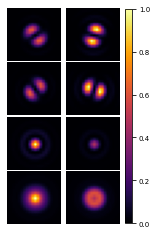

In [35]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_ret = model.pupils[0].delta
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(delta_gt,delta_ret)
print(zf_gt,zf_ret)
abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'jones_qp_retz.pdf'), bbox_inches='tight')

stack_xyz = get_xyzstack([src, abe], wollaston)
plot_xyz(stack_xyz, orientation='vertical')
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'qp_stackxyz_retz.pdf'), bbox_inches='tight')

## II. Incorporating blurring

In [134]:
fig_sub_folder = 'blurring_fig'

radius = 150
radius_true = radius + np.random.rand()*20
params['source']['delta'] = radius_true/wavelength
params['defocus']['delta_z'] =  (np.random.rand()-0.5)*50/wavelength
params['blurring']['radius'] = radius_true/wavelength

blurring_slices = 21
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

params_ret = copy.deepcopy(params)

params_ret['aberrations'] = {}
params_ret['aberrations']['jmax_list'] = [15]*4+[15]
params_ret['source']['delta'] = radius/wavelength
params_ret['blurring']['radius'] = radius/wavelength

src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

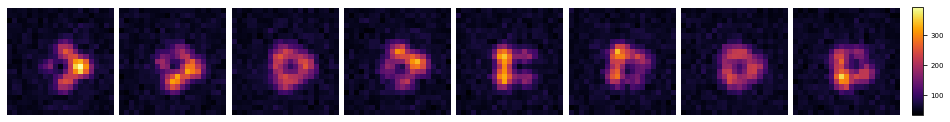

In [132]:
psfs_nb = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv)
psfs_nb.compute_psf_stack(orientation=[0,0,0], N_trim=21)
data_stack_nb = psfs_nb.model_experimental_stack(bckgd_photons=50,N_photons=10000,noise=True)
plot_zstack(data_stack_nb[...,5,:], N_z=8)
# plt.savefig(os.path.join(fig_folder,fig_sub_folder,'noblurred_stack_1z.pdf'), bbox_inches='tight')

In [135]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0], N_trim=21)

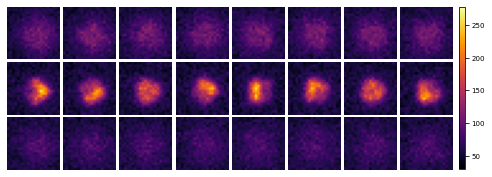

In [138]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,noise=True)
plot_zpstack(data_stack, N_p=8)
# plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurred_stack.pdf'), bbox_inches='tight')

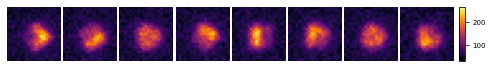

In [139]:
plot_zstack(data_stack[...,5,:], N_z=8)
# plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurred_stack_1z.pdf'), bbox_inches='tight')

In [141]:
torch_blurr2d = torch2DBlurring(radius=radius/wavelength,**params['pupil'],opt_radius=True)
torch_blurrSA = torchSABlurring(radius=radius/wavelength,**params['pupil'],opt_radius=True)

100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


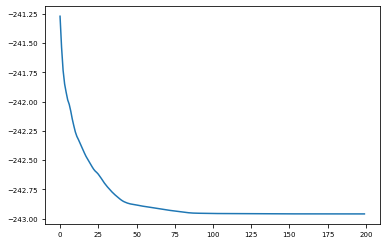

In [144]:
model_noblurr, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
                                      loss_fn=loss_loglikelihood)
plt.plot(loss_evol)

  0%|          | 0/200 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


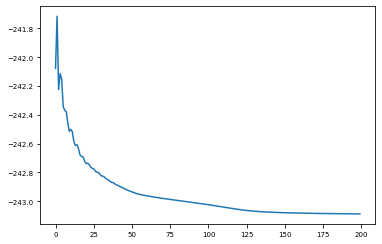

In [145]:
model_blurr2d, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
                                      loss_fn=loss_loglikelihood, blurring=torch_blurr2d)
plt.plot(loss_evol)

100%|██████████| 200/200 [02:33<00:00,  1.31it/s]


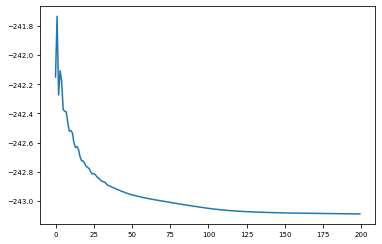

In [149]:
model_blurrSA, loss_evol = find_pupil(data_stack, params_ret, lr=3e-2, n_epochs=200, 
                                      loss_fn=loss_loglikelihood, blurring=torch_blurrSA)
plt.plot(loss_evol)

In [150]:
delta_gt, zf_gt = get_dNzf(psfs)

ret_pupil_params = get_pupils_param_dict(model_noblurr)
delta_noblurr = model_noblurr.pupils[0].delta
zf_noblurr = model_noblurr.pupils[0].alpha * delta_noblurr + ret_pupil_params['pupil1']['delta_z']
abe_noblurr = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])

ret_pupil_params = get_pupils_param_dict(model_blurr2d)
delta_blurr2d = model_blurr2d.pupils[0].delta
zf_blurr2d = model_blurr2d.pupils[0].alpha * delta_blurr2d + ret_pupil_params['pupil1']['delta_z']
abe_blurr2d = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])

ret_pupil_params = get_pupils_param_dict(model_blurrSA)
delta_blurrSA = model_blurrSA.pupils[0].delta
zf_blurrSA = model_blurrSA.pupils[0].alpha * delta_blurrSA + ret_pupil_params['pupil1']['delta_z']
abe_blurrSA = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])

In [155]:
ret_pupil_params['blurring']

{'radius': array(0.26074892, dtype=float32)}

In [151]:
print(delta_gt,delta_noblurr,delta_blurr2d,delta_blurrSA)
print(zf_gt,zf_noblurr,zf_blurr2d,zf_blurrSA)

0.27276354652883306 tensor(0.2479) tensor(0.2479) tensor(0.2479)
0.3345759741777503 tensor(0.3191) tensor(0.3075) tensor(0.3223)


In [152]:
corr = []
for bm, tag in [[abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
   corr += [cpx_corr(bm.get_pupil_array(), seo.get_pupil_array())]
np.abs(corr)

array([0.61145204, 0.98650409, 0.99457748])

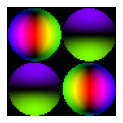

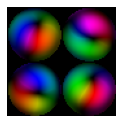

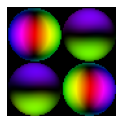

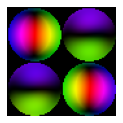

In [153]:
for bm, tag in [[seo,'gt'], [abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
    plot_jones(bm.get_pupil_array())
    # plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurr_seo_'+tag+'.pdf'), bbox_inches='tight')

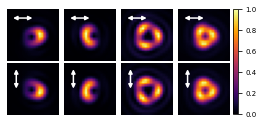

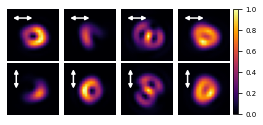

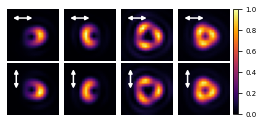

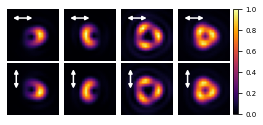

In [197]:
for bm, tag in [[seo,'gt'], [abe_noblurr,'noblurr'], [abe_blurr2d,'2d'], [abe_blurrSA,'SA']]:
    stack_xyz = get_xyzstack([src, bm], pol_seo)
    plot_xyz(stack_xyz)
    plt.savefig(os.path.join(fig_folder,fig_sub_folder,'blurr_seo_stackxyz_'+tag+'.pdf'), bbox_inches='tight')

## III. Characterization from experimental data

In [16]:
fig_sub_folder = 'exp_fig'

In [6]:
with open(os.path.join('data','data_chido.dat'), 'rb') as input_file:
    exp_data = pickle.load(input_file)

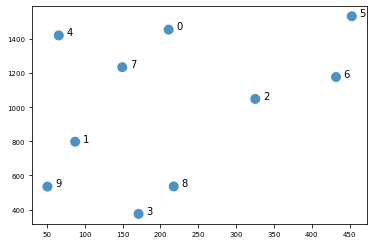

In [7]:
plt.scatter(exp_data['coords'][:,0],exp_data['coords'][:,1],s=100,c='tab:blue',alpha=0.8, edgecolors='none')
for i in range(exp_data['psf_stacks'].shape[0]):
    plt.gca().annotate(str(i), (exp_data['coords'][i,0]+10, exp_data['coords'][i,1]), size=10)

In [52]:
exp_data.keys()
exp_data['zstep']

dict_keys(['wavelength', 'psf_stacks', 'zstep', 'coords', 'qwp_angs', 'qwpstep'])

In [7]:
exp_stack = 0.24*(exp_data['psf_stacks'][0]-100)

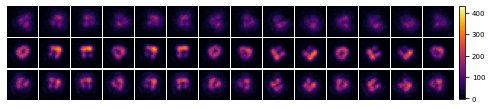

In [8]:
plot_zpstack(exp_stack, N_p=14)

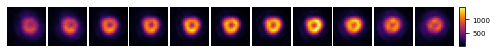

In [77]:
plot_zstack(np.sum(exp_stack, axis=-1),N_z=11)

In [9]:
params_exp = copy.deepcopy(params)

radius = 10
params_exp['source']['delta'] = radius/wavelength
params_exp['defocus']['delta_z'] =  0

z_step = exp_data['zstep']
ind_bf = -6
n_zdiv = exp_stack.shape[-2]
z_list_exp = np.arange(0,n_zdiv*z_step,z_step)
z_list_exp -= z_list_exp[ind_bf]

params_exp['zdiversity']['z_list'] = z_list_exp / wavelength

params_exp['pdiversity']['qwp_angles'] = exp_data['qwp_angs']*np.pi/180
params_exp['pdiversity']['gwp_angles'] = exp_data['qwp_angs']*np.pi/180
params_exp['pdiversity']['eta'] = 2*0.273*np.pi # value reported by thorlabs

params_exp['seo']['phi'] = 9*np.pi/40
params_exp['seo']['center'] = [-0.08,0]

In [10]:
z_list_exp

array([ 250,  200,  150,  100,   50,    0,  -50, -100, -150, -200, -250])

In [159]:
exp_data['qwp_angs']

array([  45.,   15.,  -15.,  -45.,  -75., -105., -135.])

In [11]:
src_exp = srcs.DipoleInterfaceSource(**params_exp['pupil'],**params_exp['source'])
seo_exp = wdws.SEO(**params_exp['pupil'],**params_exp['seo'])
zdiv_exp = ZDiversity(**params_exp['zdiversity'], **params_exp['pupil'])
# qwp_exp = pdivs.PDiversity_QWP(params_exp['pdiversity']['qwp_angles'])
gwp_exp = pdivs.PDiversity_GWP(params_exp['pdiversity']['gwp_angles'], params_exp['pdiversity']['eta'])
pdiv_exp = pdivs.PDiversity_Compound([gwp_exp, wollaston])

In [15]:
psfs_expmod = PSFStack([src_exp, seo_exp], zdiversity=zdiv_exp, pdiversity=pdiv_exp)
psfs_expmod.compute_psf_stack(orientation=[0,0,0], N_trim=21)

In [19]:
exp_stack.shape

(21, 21, 11, 14)

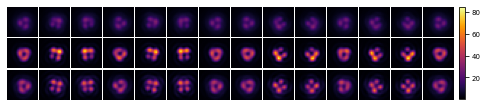

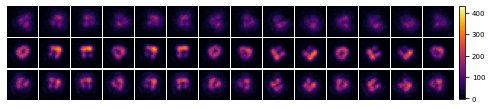

In [16]:
plot_zpstack(psfs_expmod.psf_stack, N_p=14)
plot_zpstack(exp_stack, N_p=14)

100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


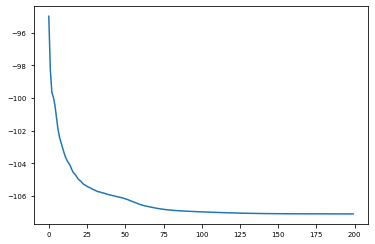

In [12]:
params_exp_ret = copy.deepcopy(params_exp)

params_exp_ret['aberrations'] = {}
params_exp_ret['aberrations']['jmax_list'] = 5*[14]#4*[9]+[13]+[1]

model, loss_evol = find_pupil(exp_stack.copy(), params_exp_ret, lr=3e-2, n_epochs=200, 
    loss_fn=loss_loglikelihood, abe='unitary', pdiv='gwplp', opt_delta=False, 
    opt_def=True, opt_a=True, tilts=True)
plt.plot(loss_evol)

100%|██████████| 200/200 [08:09<00:00,  2.45s/it]


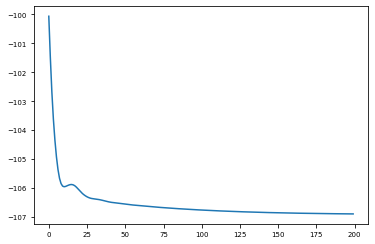

In [209]:
params_exp_ret = copy.deepcopy(params_exp)

params_exp_ret['aberrations'] = {}
params_exp_ret['aberrations']['jmax_list'] = 5*[14]#4*[9]+[13]+[1]

model_seo, loss_evol = find_pupil(exp_stack.copy(), params_exp_ret, lr=3e-2, n_epochs=200, 
    loss_fn=loss_loglikelihood, abe=None, pdiv='gwplp', opt_delta=False, 
    opt_def=True, opt_a=True, tilts=True, seo=True)
plt.plot(loss_evol)

In [232]:
ret_pupil_params['pb_bck']['a'][:,4]

array([0.5260316 , 0.5809374 , 0.59373623, 0.562821  , 0.5841864 ,
       0.5146771 , 0.49904403, 0.5436417 , 0.55997163, 0.53884983,
       0.5835151 ], dtype=float32)

In [ ]:
ret_pupil_params = get_pupils_param_dict(model)
ret_pupil_params['pupil2']['c_W'][0:2]=0
abe = UnitaryZernike(**params_exp['pupil'], 
     **ret_pupil_params['pupil2'])
pup_seq_ret = [src_exp, 
     wdws.Defocus(**params['pupil'], **ret_pupil_params['pupil1']), 
      abe]
psfs_ret = PSFStack(pup_seq_ret, zdiversity=zdiv_exp, pdiversity=pdiv_exp)
psfs_ret.compute_psf_stack(orientation=[0,0,0], N_trim=21)

ret_pupil_params_seo = get_pupils_param_dict(model_seo)
ret_seo = wdws.SEO(**params['pupil'], 
     **ret_pupil_params_seo['pupil2'])

sca_abe = UnitaryZernike(ret_pupil_params['pupil2']['c_W'], 
                                 [[1],[0],[0],[0]], **params['pupil'])

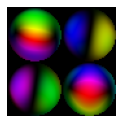

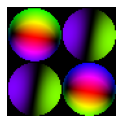

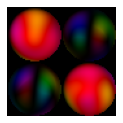

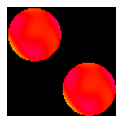

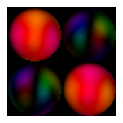

In [225]:
plot_jones(abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'exp_jones_tot.pdf'), bbox_inches='tight')

plot_jones(ret_seo.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'exp_jones_seo.pdf'), bbox_inches='tight')

plot_jones(abe.get_pupil_array() @ np.transpose(ret_seo.get_pupil_array().conj(), axes=(0,1,3,2)))
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'exp_jones_abe.pdf'), bbox_inches='tight')

plot_jones(sca_abe.get_pupil_array())
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'exp_jones_abe_sca.pdf'), bbox_inches='tight')

plot_jones(sca_abe.get_pupil_array().conj() @ abe.get_pupil_array() @ np.transpose(ret_seo.get_pupil_array().conj(), axes=(0,1,3,2)))
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'exp_jones_abe_pol.pdf'), bbox_inches='tight')

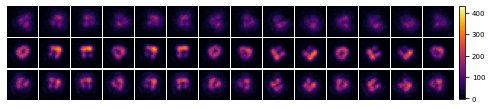

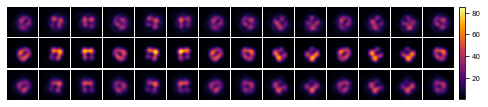

In [18]:
plot_zpstack(exp_stack, N_p=14)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'exp_pzstack.pdf'), bbox_inches='tight')
plot_zpstack(psfs_ret.psf_stack, N_p=14)
plt.savefig(os.path.join(fig_folder,fig_sub_folder,'ret_pzstack.pdf'), bbox_inches='tight')

## IV. Retrieval of scalar window

In [58]:
fig_sub_folder = 'scalar'

In [36]:
params_sca = copy.deepcopy(params)

zi = -1500; z_step = 100
z_list = np.arange(zi,-zi+z_step,z_step)

params_sca['source']['delta'] = (radius)/wavelength
params_sca['zdiversity_np']['z_list'] = z_list / wavelength

# params_ret['source']['delta'] = radius/wavelength
# params_ret['zdiversity_np']['z_list'] = z_list / wavelength

zdiv = ZDiversity(**params_sca['zdiversity_np'], **params_sca['pupil'])
src = srcs.DipoleInterfaceSource(**params_sca['pupil'],**params_sca['source'])

c_W_tetra = np.array([0.595050119555554,0.489068290032588,0.452226752326030,
    0.260435586819384,0.047750334450534,-1.039441179976503,-0.175484816149914,
    0.833009549689635,0.154895303536154,-0.824227959830304,0.039942804577574,
    -4.443116227167999,0.254621433960892,3.604115918547898,
    -0.019994555526541])/(2*np.pi)

tetra = ScalarZernike(c_A=[1], c_W=c_W_tetra[1:], 
                          **params['pupil'], index_convention='standard')

psfs = PSFStack([src, tetra], zdiversity=zdiv)
psfs.compute_psf_stack(orientation=[0,0,0])

params_sca_ret = copy.deepcopy(params_sca)
params_sca_ret['aberrations'] = {}
params_sca_ret['aberrations']['jmax_list'] = [1,15]

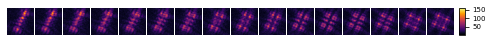

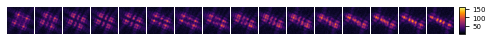

In [61]:
data_stack = psfs.model_experimental_stack(bckgd_photons=10,N_photons=50000,N_pts=60,noise=True)
plot_zstack(data_stack)
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'stack.pdf'), bbox_inches='tight')
plot_zstack(data_stack[...,:16])
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'stack1.pdf'), bbox_inches='tight')
plot_zstack(data_stack[...,15:])
plt.savefig(os.path.join(fig_folder, fig_sub_folder,'stack2.pdf'), bbox_inches='tight')

100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


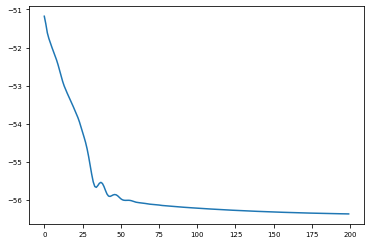

In [54]:
model, loss_evol = find_pupil(data_stack, params_sca_ret, lr=3e-2, n_epochs=200, 
    loss_fn=loss_loglikelihood, opt_def=False, pdiv=None, abe='scalar')
plt.plot(loss_evol)

100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


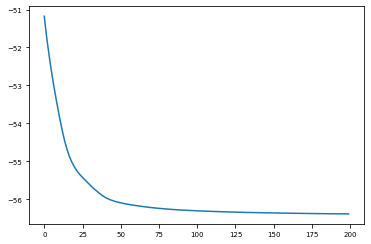

In [55]:
model_pix, loss_evol = find_pupil(data_stack, params_sca_ret, lr=3e-2, n_epochs=200, 
    loss_fn=loss_loglikelihood, opt_def=False, pdiv=None, abe='scalar_pix')
plt.plot(loss_evol)

In [52]:
get_pupils_param_dict(model_pix)

{'pupil0': {},
 'pupil1': {'delta_z': array(-0.03874689, dtype=float32)},
 'pupil2': {'phase': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'A': array(1.3515034, dtype=float32)},
 'pb_bck': {'b': array([10.871121, 10.795048, 10.989183, 10.944019, 11.021923, 10.865228,
         10.859327, 11.0178  , 11.019375, 11.193579, 11.261806, 11.267909,
         11.459739, 11.498537, 11.607718, 11.554127, 11.532356, 11.52041 ,
         11.616772, 11.476769, 11.460977, 11.50514 , 11.341836, 11.440884,
         11.407277, 11.400773, 11.480732, 11.455469, 11.504583, 11.518212,
         11.441437], dtype=float32)}}

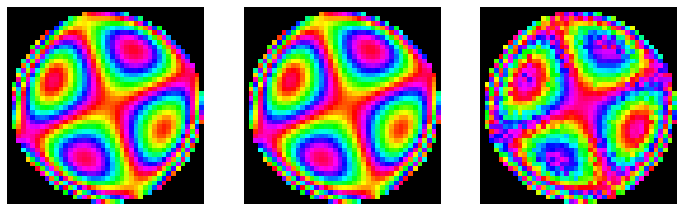

In [60]:
ret_pupil_params = get_pupils_param_dict(model)

abe = ScalarZernike(**params['pupil'], 
     **ret_pupil_params['pupil1'],index_convention='standard')

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(colorize(tetra.get_pupil_array()))
axs[1].imshow(colorize(abe.get_pupil_array()))
with torch.no_grad():
     axs[2].imshow(colorize(model_pix.pupils[1].get_pupil_array().cpu().numpy()))
for ax in axs.ravel():
     ax.set_axis_off()


fig.savefig(os.path.join(fig_folder, fig_sub_folder,'phase_masks.pdf'), bbox_inches='tight')

## 6. Retrieval with defocus and saf

In [65]:
radius = 10
alpha = 1.34421# 1.24211
delta_shift = np.random.rand()*20 /wavelength
zf_shift = (np.random.rand()-0.5)*80/wavelength
print(delta_shift*wavelength, zf_shift*wavelength)
zi = -500; z_step = 100
z_list = np.arange(zi,-zi+z_step,z_step)

params['source']['delta'] = radius/wavelength + delta_shift
params['defocus']['delta_z'] = alpha*radius/wavelength + zf_shift

params['zdiversity']['z_list'] = z_list / wavelength


params_ret['aberrations']['jmax_list'] = [15]*4+[15]
params_ret['source']['delta'] = radius/wavelength
params_ret['source']['alpha'] = 1.34421
params_ret['defocus']['delta_z'] = 0
params_ret['zdiversity']['z_list'] = z_list / wavelength
params_ret['aberrations']['c_W'] = None
params_ret['aberrations']['c_q'] = None

src = srcs.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = wdws.Defocus(**params['pupil'],**params['defocus'])
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])

10.584239487461101 26.13618872987469


### 6.1 No window

In [42]:
psfs = PSFStack([src, seo, defocus], zdiversity=zdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

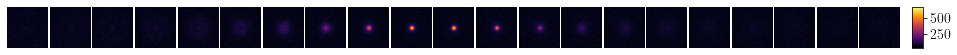

In [37]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zstack(data_stack, N_z=21)

100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


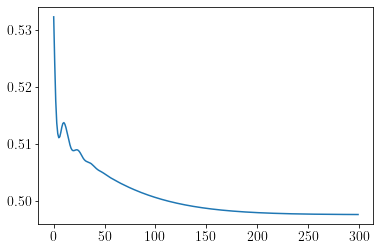

In [38]:
params_ret['aberrations']['jmax_list'] = [1,2]
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
loss_fn=loss_loglikelihood, pdiv=False, opt_def=True, opt_delta=True, abe='scalar')
plt.plot(loss_evol)

[16.99007272 10.         12.32392257]
[22.61989102 13.4421     15.90839843]


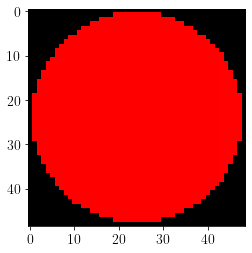

In [39]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * ret_pupil_params['pupil0']['delta'] + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)

abe = ScalarAberrations(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plt.imshow(colorize((abe.get_pupil_array())))

### 6.2 With SEO window

In [66]:
psfs = PSFStack([src, defocus, seo], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

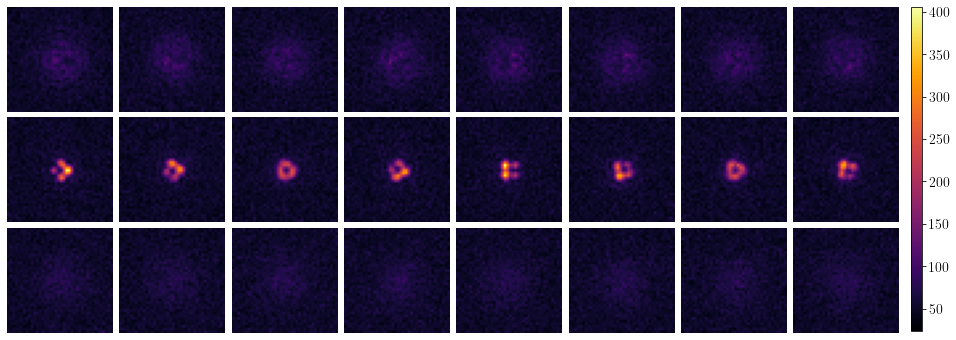

In [67]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 300/300 [00:49<00:00,  6.09it/s]


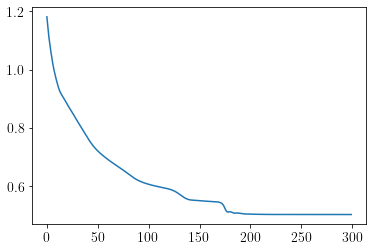

In [83]:
params_ret['aberrations']['c_W'] = None
params_ret['aberrations']['c_q'] = None
params_ret['aberrations']['jmax_list'] = [15]*5
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=False, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         10.00000038]
[39.57828873 13.4421     24.79801203]


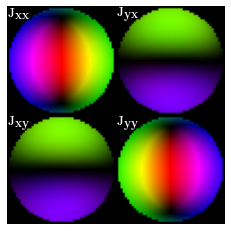

In [85]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = model.pupils[0].delta.numpy() #ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)

abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


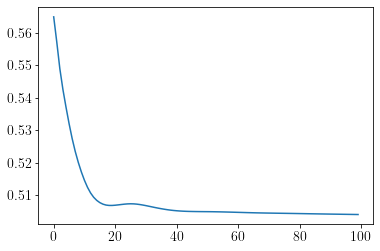

In [87]:
params_ret['aberrations']['c_W'] = ret_pupil_params['pupil2']['c_W']
params_ret['aberrations']['c_q'] = ret_pupil_params['pupil2']['c_q']
model, loss_evol = find_pupil(data_stack, params_ret, lr=0.3e-2, n_epochs=100, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=True, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         36.2526929 ]
[39.57828873 13.4421     60.16250875]
0.999558696168133


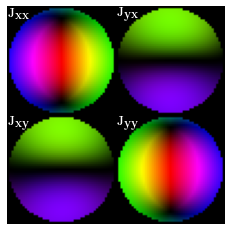

In [90]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * ret_pupil_params['pupil0']['delta'] + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)
print(np.abs(cpx_corr(abe.get_pupil_array(), seo.get_pupil_array())))
abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

### 6.3 With QP window

In [91]:
psfs = PSFStack([src, defocus, qplate], zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)
psfs.compute_psf_stack(orientation=[0,0,0],N_trim=40)

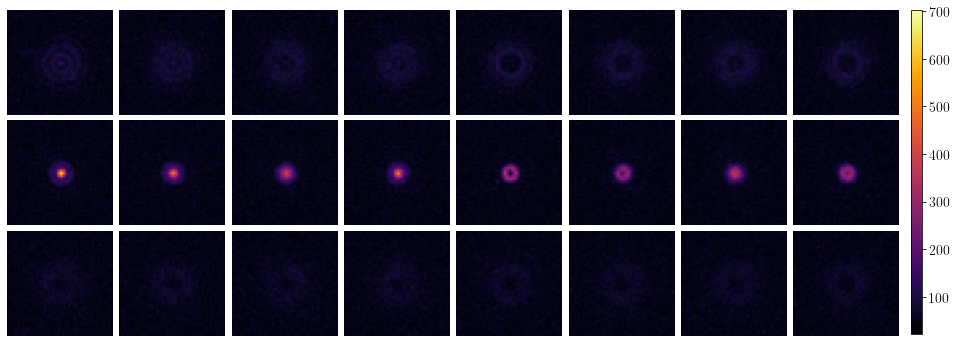

In [92]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
plot_zpstack(data_stack, N_p=8)

100%|██████████| 300/300 [00:39<00:00,  7.61it/s]


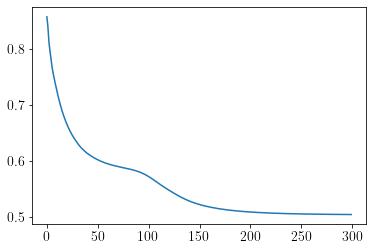

In [99]:
params_ret['aberrations']['c_W'] = None
params_ret['aberrations']['c_q'] = None
params_ret['aberrations']['jmax_list'] = [15]*5
model, loss_evol = find_pupil(data_stack, params_ret, lr=1e-2, n_epochs=300, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=False, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         10.00000038]
[39.57828873 13.4421     27.04854563]
0.9888254900396785


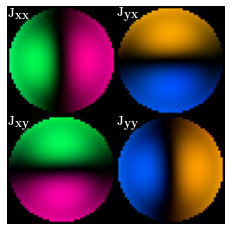

In [100]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = model.pupils[0].delta.numpy() #ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * delta_ret + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)

print(np.abs(cpx_corr(abe.get_pupil_array()[...,0,0], qplate.get_pupil_array()[...,0,0])))
abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


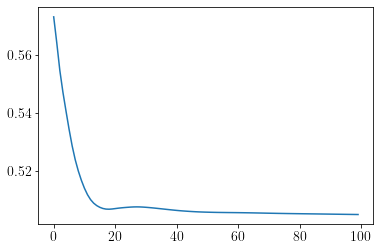

In [95]:
params_ret['aberrations']['c_W'] = ret_pupil_params['pupil2']['c_W']
params_ret['aberrations']['c_q'] = ret_pupil_params['pupil2']['c_q']
model, loss_evol = find_pupil(data_stack, params_ret, lr=0.3e-2, n_epochs=100, 
loss_fn=loss_loglikelihood, pdiv=True, opt_def=True, opt_delta=True, abe='unitary')
plt.plot(loss_evol)

[20.58423949 10.         38.03581428]
[39.57828873 13.4421     64.79682138]
0.9888254900396785


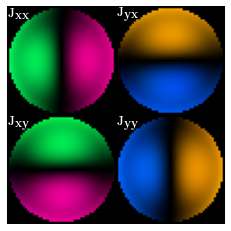

In [98]:
ret_pupil_params = get_pupils_param_dict(model)
delta_gt, zf_gt = get_dNzf(psfs)
delta_init = params_ret['source']['delta']
zf_init = delta_init *params_ret['source']['alpha']
delta_ret = ret_pupil_params['pupil0']['delta']
zf_ret = model.pupils[0].alpha * ret_pupil_params['pupil0']['delta'] + ret_pupil_params['pupil1']['delta_z']
print(np.array([delta_gt,delta_init,delta_ret])*wavelength)
print(np.array([zf_gt,zf_init,zf_ret])*wavelength)
print(np.abs(cpx_corr(abe.get_pupil_array()[...,0,0], qplate.get_pupil_array()[...,0,0])))
abe = UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
plot_jones(abe.get_pupil_array())

# Extra stuff

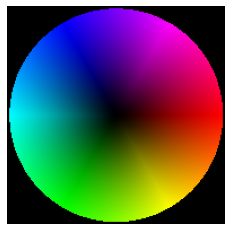

In [39]:
src2 = DipoleInterfaceSource(**params['pupil'],**params['source'])
src2.N_pts = 2**9
src2.step_f = src2.computation_size/src2.N_pts
r,phi =src2.polar_mesh()
ap = r*np.exp(1j*phi) *src2.get_aperture(dummy_ind=0)
# ap[src2.get_aperture(dummy_ind=0)==False] = np.nan 
plt.imshow(colorize(ap))
plt.gca().set_axis_off()
plt.savefig(os.path.join(fig_folder,'ampNphase_cb.pdf'), bbox_inches='tight')

In [ ]:
import scipy.io as sio
import sys
import os

In [ ]:
mat_data = sio.loadmat(os.path.join('data','Rodrigo_14Jul2021_TIRF_Run1.mat'))

In [ ]:
zdiv_mid_ind = 6
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(mat_data['beads_rodrigo'][0,...,0,ind])
    axs[1,ind].imshow(mat_data['beads_rodrigo'][0,...,zdiv_mid_ind,ind])
    axs[2,ind].imshow(mat_data['beads_rodrigo'][0,...,-1,ind])
for ax in axs.ravel():
    ax.set_axis_off()

In [ ]:
exp_stack = 0.24*(mat_data['beads_rodrigo'][0]-100)

In [ ]:
get_normNbck(exp_stack)